# 0. Import packages

In [1]:
import os
import cv2
import json
import umap
import numpy as np
from time import time
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from torchvision import datasets, transforms
from scipy.stats import differential_entropy, norm

# 1. Load image pairs

In [2]:
def load_json(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data

In [3]:
def get_img_pair_path(model_nickname, layer, num_epochs_co_act, k):
    p = f'/raid/NeuEvo/data/img_pairs/{model_nickname}/data/{layer}/img_pairs-layer={layer}-num_epochs_co_act={num_epochs_co_act}-k={k}.json'
    return p

In [172]:
model_nickname = 'vgg19_pretrained'
layers = [
    'Sequential_0_Conv2d_25',
    'Sequential_0_Conv2d_30'
]

num_epochs_co_act = 100
k = 3

tic = time()
img_pairs = {}
for layer in layers:
    p = get_img_pair_path(model_nickname, layer, num_epochs_co_act, k)
    img_pairs[layer] = load_json(p)
    toc = time()
    print(f'Load img pairs for {layer}: {toc - tic:.2f} sec')
toc = time()

Load img pairs for Sequential_0_Conv2d_25: -258.86 sec
Load img pairs for Sequential_0_Conv2d_30: -258.86 sec


In [199]:
img_pairs_data = {}
total = 0
for layer in layers:
    total += len(img_pairs[layer])
with tqdm(total=total) as pbar:
    for layer in layers:
        for k in img_pairs[layer]:
            key = int(k)
            if key not in img_pairs_data:
                img_pairs_data[key] = {}
            for pair in img_pairs[layer][k]:
                img, cnt = pair
                if img in img_pairs_data[key]:
                    img_pairs_data[key][img] += cnt
                else:
                    img_pairs_data[key][img] = cnt
            pbar.update(1)

for img in img_pairs_data:
    img_pairs_data[img] = list(img_pairs_data[img].items())

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 2562334/2562334 [09:08<00:00, 4675.48it/s]


# 2. Check similarity of the pairs

In [5]:
raw_data_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

raw_training_datasets = datasets.ImageFolder(
    '../../../../ILSVRC2012/train',
    raw_data_transform
)

In [6]:
def show_np_imgs_2_rows(imgs, title=None, subplot_titles=None):
    # Create figure
    nrows = 2
    ncols = len(imgs) // nrows
    fig, ax = plt.subplots(nrows, ncols, figsize=(2 * ncols, 2 * nrows))
    fig.tight_layout()
    
    # Create subplots
    for i, img in enumerate(imgs[:nrows * ncols]):
        row = int(i / ncols)
        col = i - row * ncols
        ax[row, col].imshow(img) 
        ax[row, col].set_axis_off()
        if subplot_titles is not None:
            ax[row, col].set_title(subplot_titles[i])

    # Title
    if title is not None:
        fig.suptitle(title, y=1.06)
        
    # Show the final plot
    plt.show()

def show_training_imgs_2_rows(img_idxs):
    imgs = []
    subplot_titles = []
    for img_idx in img_idxs:
        img = raw_training_datasets[img_idx][0]
        img = np.einsum('kij->ijk', img)
        imgs.append(img)
        subplot_titles.append(f'img: {img_idx}')
    show_np_imgs_2_rows(imgs)

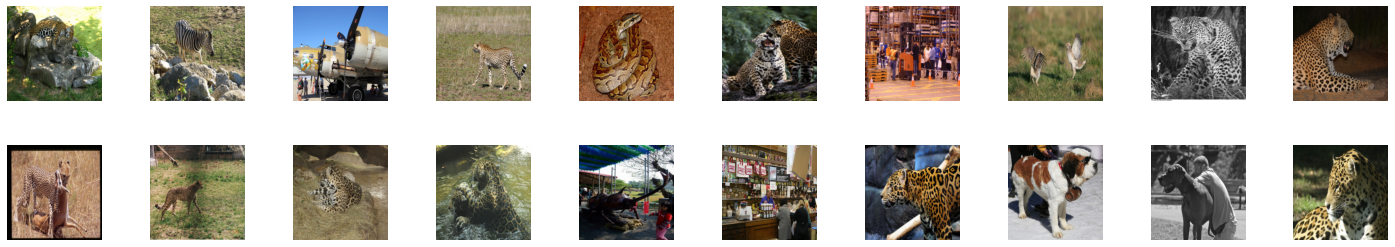

In [227]:
img = 371028
neighbors = [p[0] for p in img_pairs_data[img] if p[1] > 1]
show_training_imgs_2_rows([img] + neighbors[:19])

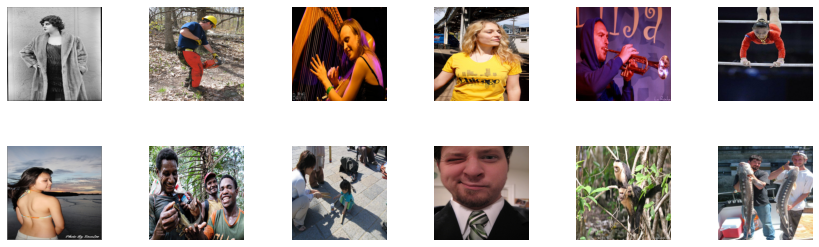

In [226]:
img = 730007
neighbors = [p[0] for p in img_pairs_data[img] if p[1] > 1]
show_training_imgs_2_rows([img] + neighbors[:19])

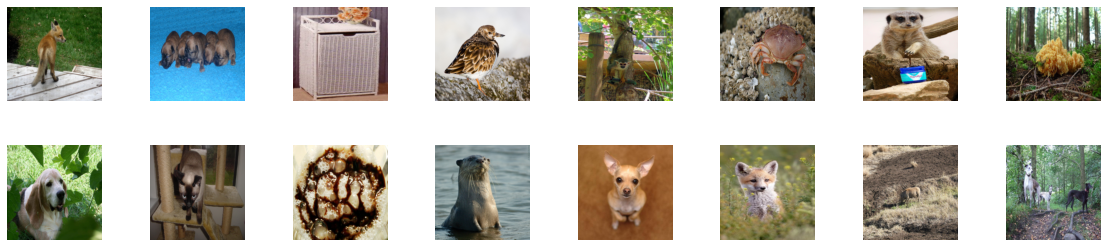

In [225]:
img = 355500
neighbors = [p[0] for p in img_pairs_data[img] if p[1] > 1]
show_training_imgs_2_rows([img] + neighbors[:19])

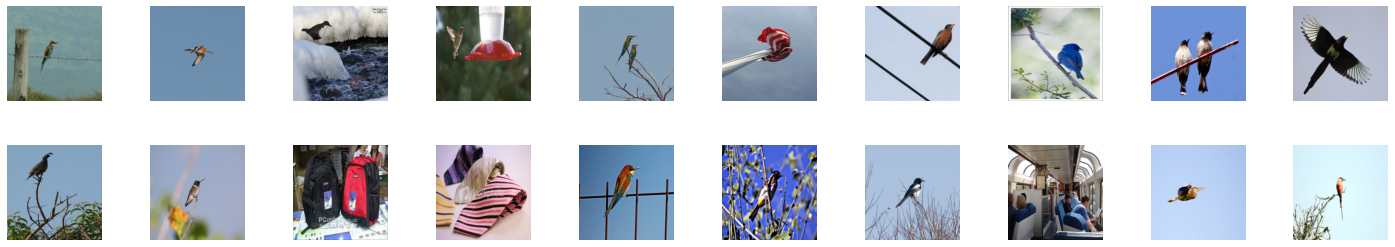

In [224]:
img = 119162
neighbors = [p[0] for p in img_pairs_data[img] if p[1] > 1]
show_training_imgs_2_rows([img] + neighbors[:19])

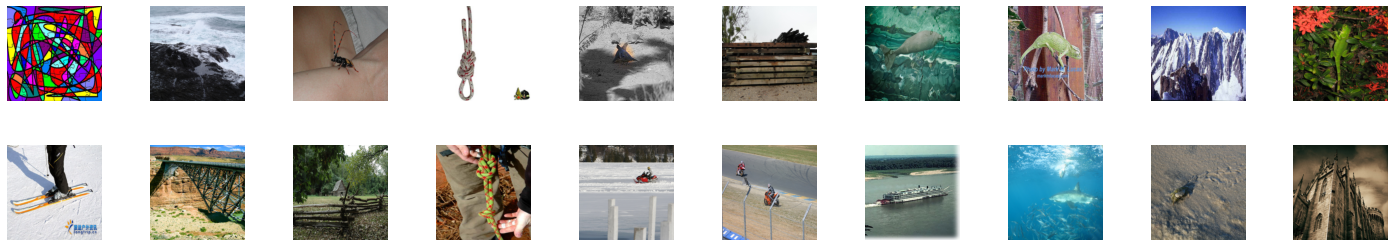

In [223]:
img = 784868
neighbors = [p[0] for p in img_pairs_data[img] if p[1] > 1]
show_training_imgs_2_rows([img] + neighbors[:19])

# 3. Load vocab

In [82]:
def get_stimulus_path(model_nickname):
    return f'/raid/NeuEvo/data/stimulus/{model_nickname}/data/stimulus-topk_s=20.json'

In [83]:
base_stimulus = load_json(get_stimulus_path('vgg19_pretrained'))

In [86]:
num_imgs = len(raw_training_datasets)
base_vocab = {}
for layer in base_stimulus:
    for neuron_idx, imgs in enumerate(base_stimulus[layer]):
        for img in imgs:
            if img not in base_vocab:
                base_vocab[img] = 0
            base_vocab[img] += 1

num_covered_imgs = len(base_vocab)
print(f'{num_covered_imgs} imgs are covered ({num_covered_imgs / num_imgs * 100:.2f})%')

56475 imgs are covered (4.41)%


# 4. For an un-seen image (not in vocab), what seen-images (in vocab) are paired?

img: 304256
[203208, 239340, 410940, 20580, 533767, 78745, 305259, 212149, 651236, 561934, 304502, 304998, 886957, 75974, 891243, 307665, 273425, 979220, 481372]


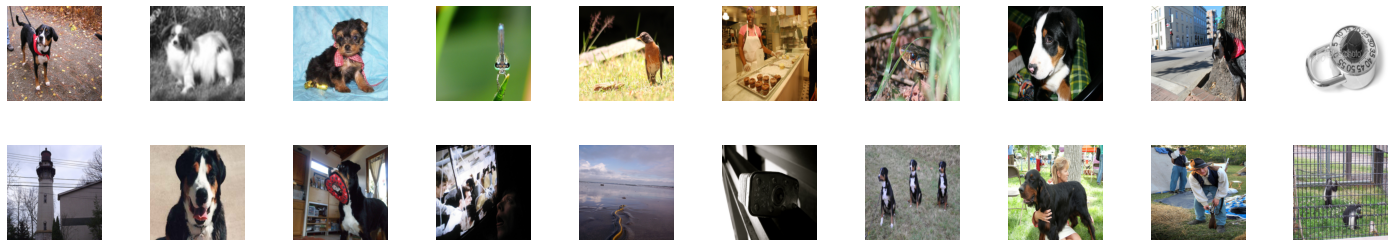

In [214]:
dogs_in_vocab = [304256, 305414, 205535, 196017, 295647, 259491, 238003]
for img in dogs_in_vocab[:1]:
    print(f'img: {img}')
    neighbors = [p[0] for p in img_pairs_data[img] if p[1] >= 2]
    print(neighbors[:19])
    show_training_imgs_2_rows([img] + neighbors[:19])

In [216]:
add_covered_imgs = {}
for img in base_vocab:
    neighbors = [p[0] for p in img_pairs_data[img] if p[1] >= 2]
    for neighbor in neighbors:
        if neighbor not in base_vocab:
            if neighbor not in add_covered_imgs:
                add_covered_imgs[neighbor] = 0
            add_covered_imgs[neighbor] += 1

In [220]:
num_covered_imgs = len(add_covered_imgs)
print(f'{num_covered_imgs} imgs are additionally and directly covered ({num_covered_imgs / num_imgs * 100:.2f})%')

535634 imgs are additionally and directly covered (41.81)%


img: 216185, #covered: 3


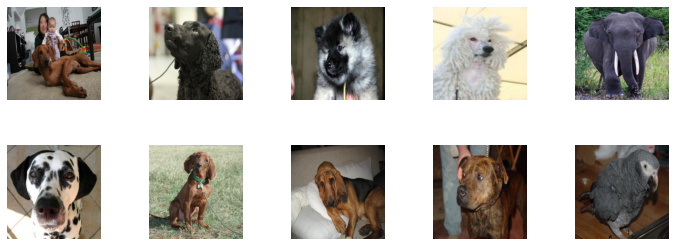

img: 1190352, #covered: 5


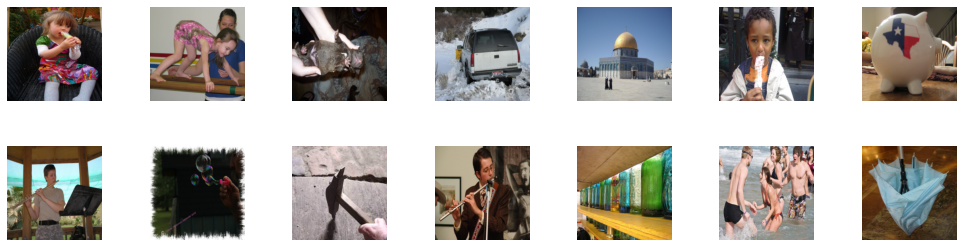

img: 200296, #covered: 1


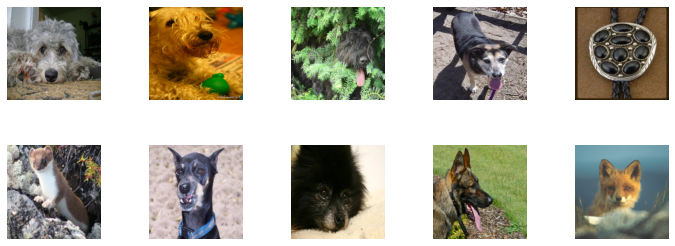

In [243]:
vocab_imgs = list(base_vocab.keys())
sampled_vocab_imgs = np.random.choice(vocab_imgs, 3)
for img in sampled_vocab_imgs:
    print(f'img: {img}, #covered: {base_vocab[img]}')
    neighbors = [p[0] for p in img_pairs_data[img] if p[1] >= 2]
    show_training_imgs_2_rows([img] + neighbors[:19])